In [1]:
import numpy as np
import pandas as pd
import sys, os, glob, corner
import matplotlib.pyplot as plt
from jaxstar.utils import *

In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='sans-serif')
from matplotlib import rc
rc('text', usetex=True)
%matplotlib inline

In [3]:
from sklearn.neighbors import KDTree
def normalize(x, centers=np.array([1, 7]), widths=np.array([0.6, 14])):
    return (x - centers) / widths

def choose_simdata(simdata, samples):
    simd = np.array(simdata[['mass_true', 'age_true']])
    tree = KDTree(normalize(simd))
    distances, idx = tree.query(normalize(samples), k=1)
    print (np.max(distances))
    return distances.ravel(), idx.ravel()

from scipy.stats import ks_2samp
def check_sample(dsmp, dsim):
    _, pval = ks_2samp(dsmp.mass_true, dsim.mass_true)
    plt.figure()
    plt.xlabel("mass")
    plt.hist(dsim.mass_true, density=True, bins=100, histtype='step', lw=1, cumulative=True, label='original')
    plt.hist(dsmp.mass_true, density=True, bins=100, histtype='step', lw=1, cumulative=True)
    plt.title("$p=%.2f$"%pval)
    plt.legend(loc='best');

    #%%
    _, pval = ks_2samp(dsmp.age_true, dsim.age_true)
    plt.figure()
    plt.xlabel("age")
    plt.hist(dsim.age_true, density=True, bins=100, histtype='step', lw=1, cumulative=True, label='original')
    plt.hist(dsmp.age_true, density=True, bins=100, histtype='step', lw=1, cumulative=True)
    plt.title("$p=%.2f$"%pval)
    plt.legend(loc='best');

    #%%
    plt.figure()
    plt.plot(dsim.mass_true, dsim.age_true, ',', label='original')
    plt.plot(dsmp.mass_true, dsmp.age_true, '.')
    plt.legend(loc='best');
    
def get_posterior_samples(d, postdir, agekey="age", n_samples=20000):
    samples = []
    for i, kepid in enumerate(d.kepid):
        filename = postdir + "%s_samples.csv"%("%05d"%kepid)
        dp = pd.read_csv(filename)[['mass', agekey]]
        samples.append(np.array(dp)[:n_samples])
    samples = np.array(samples)
    return samples

In [4]:
def define_sample(funcname, dsim, n_samples, postdir="../posteriors_simulated_cks/", ntruths=1e6, namebase=''):
    name = funcname + namebase
    print (name)
    if n_samples != 800:
        name += "_s%d"%n_samples
    psamples = globals()[funcname](int(ntruths), mmin, mmax)
    dists, idx = choose_simdata(dsim, psamples)
    dsamples = dsim.iloc[idx[:n_samples]].reset_index(drop=True)
    dtruths = pd.DataFrame(data={"mass_true": psamples.T[0], "age_true": psamples.T[1]})
    check_sample(dsamples, dtruths)  
    samples = get_posterior_samples(dsamples, postdir) # posterior samples
    dsamples.to_csv("%s.csv"%name, index=False)
    np.savez("%s.npz"%name, samples=samples, dtruths=dtruths)

In [5]:
age_upper = lambda mass: -30 * (mass-1.25) + 5.

def get_valid_ma(m, a, mmin, mmax):
    idx = (age_upper(m) > a) & (mmin < m) & (m < mmax) & (0 < a) & (a < 14)
    return np.array([m[idx], a[idx]]).T

def func0(Nsample, mmin, mmax, seed=123):
    np.random.seed(seed)
    m = np.random.rand(Nsample) * (mmax-mmin) + mmin
    a = np.random.rand(Nsample) * 14
    return get_valid_ma(m, a, mmin, mmax)

def func1(Nsample, mmin, mmax, seed=123):
    np.random.seed(seed)
    m = 1.05 + 0.1 * np.random.randn(Nsample)
    a = 7 + np.random.randn(Nsample) * 1.5
    return get_valid_ma(m, a, mmin, mmax)

def func2(Nsample, mmin, mmax, seed=123):
    np.random.seed(seed)
    m = 0.8 + 0.2 * np.random.randn(Nsample)
    a = 4 + np.random.randn(Nsample) * 2
    return get_valid_ma(m, a, mmin, mmax)

def func3(Nsample, mmin, mmax, seed=123):
    np.random.seed(seed)
    m = 0.8 + 0.2 * np.random.randn(Nsample)
    a = 10 + np.random.randn(Nsample) * 2
    return get_valid_ma(m, a, mmin, mmax)

def func4(Nsample, mmin, mmax, seed=123):
    np.random.seed(seed)
    m = 0.8 + 0.2 * np.random.randn(Nsample)
    a = 3 + np.random.randn(Nsample) * 2
    return get_valid_ma(m, a, mmin, mmax)

def func5(Nsample, mmin, mmax, seed=123):
    np.random.seed(seed)
    m = 0.8 + 0.2 * np.random.randn(Nsample)
    a = 11 + np.random.randn(Nsample) * 2
    return get_valid_ma(m, a, mmin, mmax)

In [6]:
mmin, mmax, femax = 0.75-0.05, 1.25+0.05, 0.4

### results_noidx: use true parameters to select sample and remove bad fits later

In [7]:
d = pd.read_csv("../simulated-cks_results.csv")
idx = (np.abs(d.feh_true) < femax) & (mmin < d.mass_true) & (d.mass_true < mmax)# & (d.idx)
idxmax = len(d)
dsim = d[idx&(d.index<idxmax)].reset_index(drop=True)
len(dsim)

5093

### select stars like we do for real data

In [21]:
d = pd.read_csv("../simulated-cks_results.csv")
idx = (np.abs(d.feh_true) < femax) & (mmin < d.iso_mass) & (d.iso_mass < mmax) & (d.idx)
idxmax = len(d)
dsim = d[idx&(d.index<idxmax)].reset_index(drop=True)
len(dsim)

4650

In [19]:
n_samples = 800

func0
0.042678973150051536


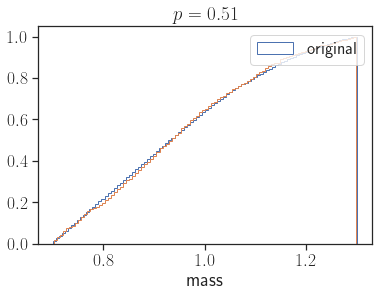

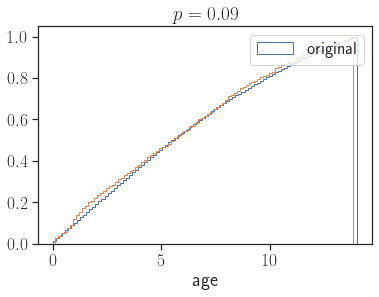

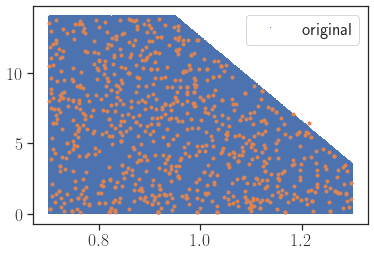

In [20]:
funcname = 'func0'
define_sample(funcname, dsim, n_samples)

func1
0.04322744357517911


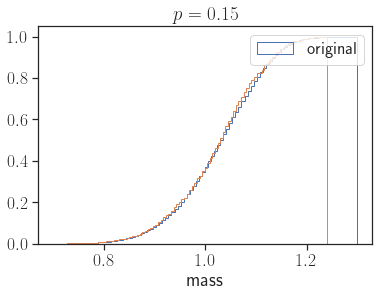

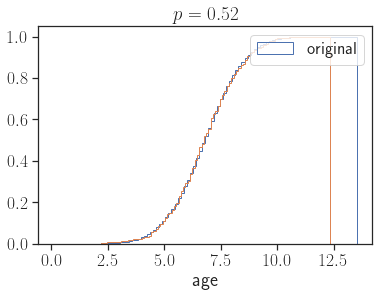

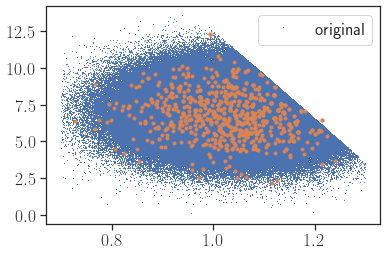

In [22]:
funcname = 'func1'
define_sample(funcname, dsim, n_samples)

func2
0.0425422789126238


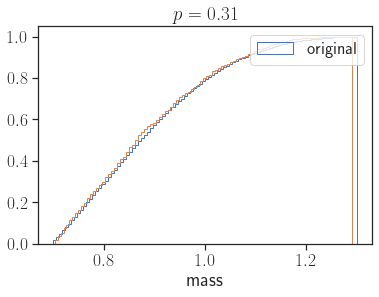

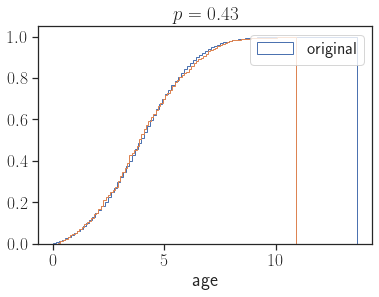

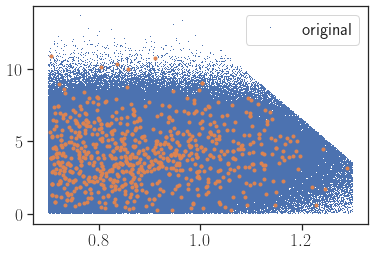

In [23]:
funcname = 'func2'
define_sample(funcname, dsim, n_samples)

func3
0.04268936759368567


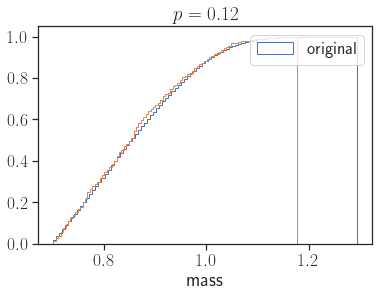

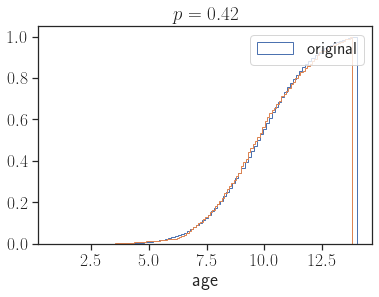

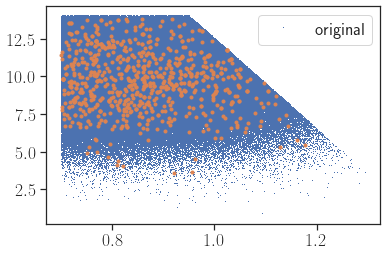

In [24]:
funcname = 'func3'
define_sample(funcname, dsim, n_samples)